In [5]:
#basic
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle as pk

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings
#tensorflow and keras
from tensorflow import keras
from keras.models import load_model, Model

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# cascid
from cascid.models.StackedModel import StackedModel
from cascid.configs.config import DATA_DIR
from cascid.configs.pad_ufes_cnf import PAD_UFES_DIR
from cascid.datasets.pad_ufes import database as pad_ufes
from cascid.datasets.pad_ufes import images
from cascid.datasets.isic import database as isic

RANDOM_STATE = 42
NN_PATH = '/home/dell/.cascid_data/experiments_final/final_isic/resnet34/aug_hq/checkpoint_epoch0075'
RFC_PATH = PAD_UFES_DIR / 'rfc_clf_bin_final.joblib'
OUTPUT_PATH = DATA_DIR / 'final_models' / 'stacked_01'

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

rfc = joblib.load(RFC_PATH)
NN = load_model(NN_PATH)

In [3]:
StackModel = StackedModel(NN, rfc)
StackModel_2 = StackedModel(NN, rfc, NN_include_top=False)

x_train_metadata, x_train_stacked, x_test, y_train_metadata, y_train_stacked, y_test = pad_ufes.get_train_test_metadata(return_img_id=True)
image_shape = StackModel.get_input_image_shape()

x_train_nn = x_train_stacked['img_id']
x_train_nn = x_train_nn.apply(lambda img_id : images.get_hq_image(img_id, image_shape=image_shape)).to_numpy()
x_train_nn = np.array([i for i in x_train_nn])
x_train_rfc = x_train_stacked.drop('img_id', axis=1).to_numpy().astype(np.float64)


x_test_nn = x_test['img_id']
x_test_nn = x_test_nn.apply(lambda img_id : images.get_hq_image(img_id, image_shape=image_shape)).to_numpy()
x_test_rfc = x_test.drop('img_id', axis=1).to_numpy().astype(np.float64)
x_test_nn = np.array([i for i in x_test_nn])

StackModel.fit(x_train_nn, x_train_rfc, y_train_stacked)
StackModel_2.fit(x_train_nn, x_train_rfc, y_train_stacked)

## Using NN as classifier

9/9 [==============================] - 11s 1s/step
Accuracy: 82.909%


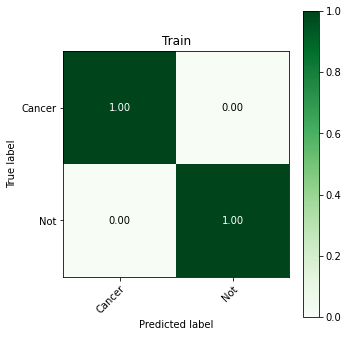

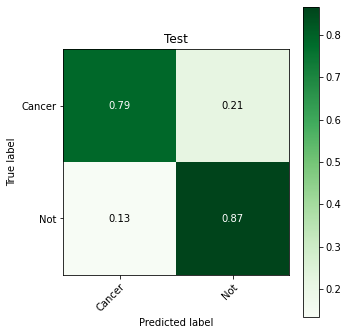

In [3]:
preds_train = StackModel.predict(x_train_nn, x_train_rfc)
preds_test = StackModel.predict(x_test_nn, x_test_rfc)
plot_confusion_matrix(y_train_stacked, preds_train, sorted(["Not", "Cancer"]), title="Train")
plot_confusion_matrix(y_test, preds_test, sorted(["Not", "Cancer"]), title="Test")
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print("Accuracy: {:.3f}%".format(100*acc))

## Using NN as feature extractor

9/9 [==============================] - 11s 1s/step
Accuracy: 84.364%


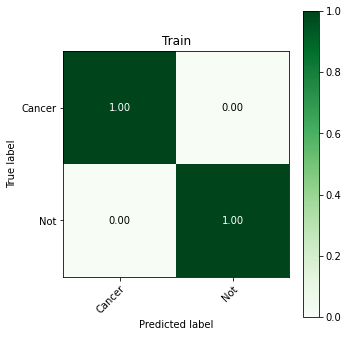

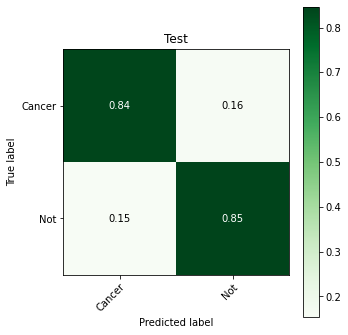

In [4]:
preds_train = StackModel_2.predict(x_train_nn, x_train_rfc)
preds_test = StackModel_2.predict(x_test_nn, x_test_rfc)
plot_confusion_matrix(y_train_stacked, preds_train, sorted(["Not", "Cancer"]), title="Train")
plot_confusion_matrix(y_test, preds_test, sorted(["Not", "Cancer"]), title="Test")
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print("Accuracy: {:.3f}%".format(100*acc))

## Hyperparameters

In [11]:
try:
    with open(DATA_DIR / 'pred_cache.pickle', 'rb') as f:
        p = pk.load(f)
    x_train_nn = p["x_train_nn"]
    x_train_nn_features = p["x_train_nn_features"]
    x_train_rfc = p["x_train_rfc"]
    x_test_nn = p["x_test_nn"]
    x_test_rfc = p["x_test_rfc"]
    x_train_nn_classification = p["x_train_nn_classification"]
    x_train_metadata_classification = p["x_train_metadata_classification"]
    x_test_nn_features = p["x_test_nn_features"]
    x_test_nn_classification = p["x_test_nn_classification"]
    x_test_metadata_classification = p["x_test_metadata_classification"]
    x_train_features = p["x_train_features"]
    x_train_classification = p["x_train_classification"]
    x_test_features = p["x_test_features"]
    x_test_classification = p["x_test_classification"]
except (FileNotFoundError, KeyError) as e:
    feature_extractor = Model(inputs = NN.input, outputs=NN.layers[-2].output) # Model outputing last layer before classification layer
    x_train_nn_features = feature_extractor.predict(x_train_nn)
    x_train_nn_classification = NN.predict(x_train_nn)
    x_train_metadata_classification = rfc.predict_proba(x_train_rfc)
    x_test_nn_features = feature_extractor.predict(x_test_nn)
    x_test_nn_classification = NN.predict(x_test_nn)
    x_test_metadata_classification = rfc.predict_proba(x_test_rfc)
    x_train_features = np.hstack([x_train_nn_features, x_train_metadata_classification])
    x_train_classification = np.hstack([x_train_nn_classification, x_train_metadata_classification])
    x_test_features = np.hstack([x_test_nn_features, x_test_metadata_classification])
    x_test_classification = np.hstack([x_test_nn_classification, x_test_metadata_classification])

    preds = {
        "x_train_nn" : x_train_nn,
        "x_train_nn_features": x_train_nn_features,
        "x_train_rfc" : x_train_rfc,
        "x_test_nn" : x_test_nn,
        "x_test_rfc" : x_test_rfc,
        "x_train_nn_classification": x_train_nn_classification,
        "x_train_metadata_classification": x_train_metadata_classification,
        "x_test_nn_features": x_test_nn_features,
        "x_test_nn_classification": x_test_nn_classification,
        "x_test_metadata_classification": x_test_metadata_classification,
        "x_train_features": x_train_features,
        "x_train_classification": x_train_classification,
        "x_test_features": x_test_features,
        "x_test_classification": x_test_classification,
    }
    with open(DATA_DIR / 'pred_cache.pickle', 'wb') as f:
        pk.dump(preds, f)


In [24]:
params = {
    "max_samples" : list(np.arange(0.15, 0.26, 0.01)),
    "n_estimators" : list(range(350, 401, 5)),
    "max_depth" : list(range(7,14)),
}

rfc = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1)

In [25]:
CV_rfc.fit(x_train_features, y_train_stacked)
best_features_rfc = CV_rfc.best_estimator_

In [26]:
rfc = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1)
CV_rfc.fit(x_train_classification, y_train_stacked)
best_classification_rfc = CV_rfc.best_estimator_

## Performance

Accuracy: 88.364%


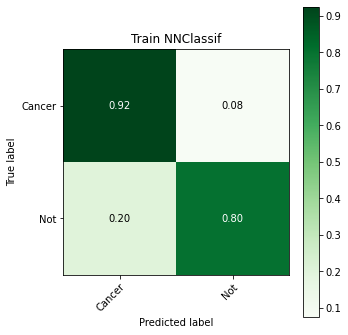

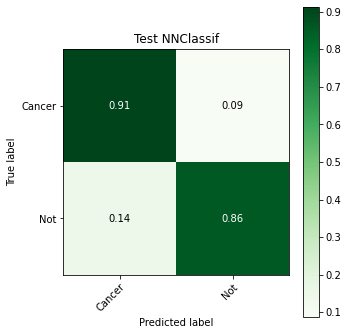

In [27]:
preds_train = best_classification_rfc.predict(x_train_classification)
preds_test = best_classification_rfc.predict(x_test_classification)
plot_confusion_matrix(y_train_stacked, preds_train, sorted(["Not", "Cancer"]), title="Train NNClassif")
plot_confusion_matrix(y_test, preds_test, sorted(["Not", "Cancer"]), title="Test NNClassif")
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print("Accuracy: {:.3f}%".format(100*acc))

Accuracy: 86.545%


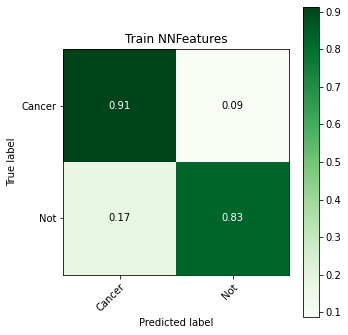

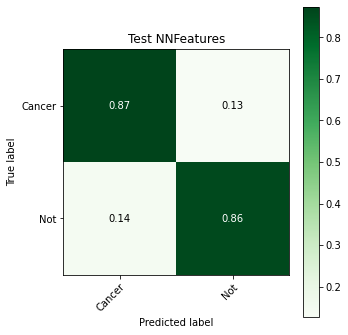

In [28]:
preds_train = best_features_rfc.predict(x_train_features)
preds_test = best_features_rfc.predict(x_test_features)
plot_confusion_matrix(y_train_stacked, preds_train, sorted(["Not", "Cancer"]), title="Train NNFeatures")
plot_confusion_matrix(y_test, preds_test, sorted(["Not", "Cancer"]), title="Test NNFeatures")
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print("Accuracy: {:.3f}%".format(100*acc))

In [29]:
print(best_classification_rfc)

RandomForestClassifier(max_depth=10, max_samples=0.16, n_estimators=365,
                       random_state=42)


## Saving best

In [34]:
best = StackedModel(NN, rfc, NN_include_top=True, stacker_model=RandomForestClassifier(max_depth=10, max_samples=0.16, n_estimators=365, random_state=42))
best.fit(x_train_nn, x_train_rfc, y_train_stacked)
best.save(OUTPUT_PATH)

18/18 [==============================] - 22s 1s/step


INFO:tensorflow:Assets written to: /home/cedip/.cascid_data/final_models/stacked_01/_nn/assets


INFO:tensorflow:Assets written to: /home/cedip/.cascid_data/final_models/stacked_01/_nn/assets
